<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/iCarl_centercrop_last_chance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install 'import_ipynb'
!pip3 install 'tqdm'

!rm -r IncrementalLearning
# upload work files from your git hub repository
import sys

!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb

path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')

!pip3 install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=4f44ee0f0b8e345b88cd09ada64ecc90e2802a95114ff5c5ab14ae28e5dd5867
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
rm: cannot remove 'IncrementalLearning': No such file or directory
Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 890 (delta 10), reused 0 (delta 0), pack-reused 867
Receiving objects: 100% (890/890), 11.22 MiB | 34.93 MiB/s, done.
Resolving deltas: 100% (520/520), done.


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
from torchvision.datasets import VisionDataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Subset, DataLoader
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from sklearn.manifold import TSNE
import import_ipynb
# from IncrementalLearning.cifar100 import ilCIFAR100

from IncrementalLearning.resnet_cifar import resnet32
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


In [3]:
# SOME UTILS FUNCTIONS

def tensor2im(input_image, imtype=np.uint8):
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().detach().float().numpy()
        if image_numpy.shape[0] == 1:
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)): 
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)


ROOT = './data'
class ilCIFAR100(VisionDataset):
    """
    Extends CIFAR100 class. Split the dataset into 10 batches, each one containing 10 classes.
    You can retrieve the batches from the attribute "batches", it has different structure according to
    test and train CIFAR100 splits:
        - train -> batches is a dictionary {0:{'train':indexes, 'val':indexes}...} 
        - test -> batches is a dictionary {0:indexes...}
    where the keys are the batch number.
 
    Args:
        root (string): Root directory of dataset where directory
            `cifar-10-batches-py` exists or will be saved to if download is set to True.
        seed(int): used to ensure reproducibility in shuffling operations.
        val_size(float, optional): between 0 and 1, fraction of data used for validation.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, `transforms.RandomCrop`
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    def __init__(self,classes_per_batch, seed, val_size=0.1, train='train', transform=None, target_transform=False, 
    download=True):
        
        super(ilCIFAR100, self).__init__(root=0)
        self.classes_per_batch=classes_per_batch
        self.coarse_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver','bed','bee','beetle','bicycle','bottle',
                              'bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle',
                              'chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup', 'dinosaur',
                              'dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard',
                              'lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain',
                              'mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree',
                              'plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket',
                              'rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider',
                              'squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor',
                              'train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]


        
        self.__rs = seed # set random seed 
        self.train = train
        self._transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
 
        self._transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        # if train:
        #     self.batches = self.__make_train_batches(val_size)
        # else:
        #     self.batches = self.__make_test_batches()
        if self.train == 'train':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self._transform_train)
        elif self.train == 'exemplars':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self._transform_test)
        else:
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=False,
                                        download=True, transform=self._transform_test)
          
        self.targets = np.array(self.dataset.targets) # make targets an array to exploit masking
        random.seed(seed)
        self.classes = random.sample(range(0, 100), 100)
        #self.classes = self.classes.reshape((10, -1)) # each row contains the classes for the corrisponding batch
        #print(self.classes)
        self.__dictionary = {}
        for i, c in enumerate(self.classes):
          self.__dictionary[c] = i
 
 
    def get_dict(self):
      return self.__dictionary
      
    def __getitem__(self, index):
        return index,self.dataset.__getitem__(index)[0],self.dataset.__getitem__(index)[1]

    def __len__(self):
        return self.dataset.__len__()

    def getbatches(self):
      classlist=self.classes
      batches=[]
      for i in range(0,int(100/self.classes_per_batch)):
        #print(i)
        batch=classlist[int(i*self.classes_per_batch):int(i*10+self.classes_per_batch)]
        batches.append(batch)
      return batches

    def get_batch_indexes(self):
      classlist=self.classes
      numclass=self.classes_per_batch
      batch_indexes=[]
      for i in range(0,int(100/self.classes_per_batch)):
        batch=classlist[int(i*numclass):int(i*numclass+numclass)]
        mask=np.isin(self.targets,batch)
        indexes=np.array(np.arange(len(self.dataset.targets)))
        indexes=indexes[mask]
        batch_indexes.append(indexes)
      return batch_indexes

    def get_class_indexes(self,label):
      indexes = np.array(np.arange(len(self.dataset.targets)))
      labels = self.dataset.targets
      mask = np.isin(labels, label)
      indexes = indexes[mask]
 
      return indexes
    def get_train_val(self,valid):
      batches=self.get_batch_indexes()
      train=[]
      val=[]
      for batch in batches:
        #print(type(batch))
        random.shuffle(batch)
        valbatch=batch[0:int(valid*len(batch))]
        trainbatch=batch[int(valid*len(batch)):]
        train.append(trainbatch)
        val.append(valbatch)
      return train,val

In [5]:
class icarl(nn.Module):
  def __init__(self, randomseed, name):
    super(icarl, self).__init__()
    self.model = resnet32(num_classes=100)
    self.feature_extractor = self.model.features
    self.lr = 2
    self.gamma = 0.2
    self.weight_decay =1e-5 
    self.milestones = [49,63]
    self.batch_size = 128
    self.numepochs = 70
    self.n_classes = 0
    self.n_known = 0
    self.feature_size = 64
    self.momentum = 0.9
    self.criterion = nn.BCEWithLogitsLoss()
    self.compute_means = True
    self.exemplar_means = None
    self.exemplar_sets = []
    self.exemplar_labels = []
    self.NUM_BATCHES = 10
    self.randomseed = randomseed
    self.trainloader = None
    self.testloader = None
    self.CLASSES_PER_BATCH = 10
    self.original_training_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train='train')
    self.original_exemplar_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train='exemplars')
    self.original_test_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train='test')
    self.name = name+'_'+str(randomseed)

    self.y_pred = []
    self.y_test = []

    self.classes_seen = 0
    self.diz = self.original_training_set.get_dict()

    # tsne attributes
    self.tsne_labels = self.original_training_set.getbatches()[0][:5]
    tsne_train_idxs = []
    hexcolors = ['#0b649e', '#d85c20','#c43509', '#21130d','#741a00']
    for label in self.tsne_labels:
      tsne_train_idxs.append(self.original_training_set.get_class_indexes(label).tolist())

    
    self.tsne_train_idxs = tsne_train_idxs
    self.label2hexcolor = {label:hexcolor for label, hexcolor in zip(self.tsne_labels, hexcolors)}
    self.label2color ={label:color for label, color in zip(self.tsne_labels, ['blue','orange','red','black','brown'])}


  def update_parameters(self):
    old_model = copy.deepcopy(self)
    old_model.eval()
    old_model.to('cuda')
    n_classes = self.classes_seen+self.CLASSES_PER_BATCH
    print(n_classes)
    optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
    for epoch in tqdm(range(self.numepochs)):
        
      for _, inputs, labels in self.trainloader:
        inputs = inputs.float().cuda()
        labels = torch.tensor([self.diz[c.item()] for c in labels])

        labels=labels.to('cuda')
        optimizer.zero_grad()
        outputs=self.forward(inputs)

        labels_encoded = F.one_hot(labels,100).float().cuda() #CAMBIARE ONE_HOT
        
        if self.classes_seen:
          old_target = old_model.forward(inputs).cuda()
          old_target = torch.sigmoid(old_target).cuda()
          
          target = torch.cat((old_target[:,:self.classes_seen], labels_encoded[:, self.classes_seen:]), dim=1)
          loss = self.criterion(outputs, target)
        else:
          loss = self.criterion(outputs,labels_encoded) 

        loss.backward()
        optimizer.step()
      
      scheduler.step()

  def classify_nme(self, input_batch):
    min_distances = float('inf')*torch.ones(len(input_batch)).cuda() # shape: batch_size --> 128
    y_pred = torch.zeros(len(input_batch), dtype=torch.int8).cuda() # shape: batch_size --> 128
    input_features = self.feature_extractor(input_batch) # shape: (batch_size, feature_size) --> (128, 64)

    for i in range(len(self.exemplar_sets)):
      ex_mean = self.exemplar_means[i,:]

      # compute distances between inputs features and exemplar set means
      pdist = nn.PairwiseDistance(p=2)
      distances = pdist(input_features, ex_mean) # shape: batch_size --> 128

      # update min distancies and predicted labels
      mask = distances < min_distances
      min_distances[mask] = distances[mask]
      y_pred[mask] = self.exemplar_labels[i]

    return y_pred
    

  def get_new_exemplars(self, batch, m):
    new_ex_idxs = random.sample(list(batch), m)

    # memorizza tutti i tensori degli exemplars della singola classe
    ex_tensors = torch.zeros((m, 3, 32, 32), dtype=torch.float)
    for i, ex_idx in enumerate(new_ex_idxs):
      _, ex, _ = self.original_training_set.__getitem__(ex_idx)
      ex_tensors[i] = ex

    intero = int(m/4)
    self.exemplar_sets.append(new_ex_idxs[:intero]) 

    # create m collage images
    for i, idx in enumerate(new_ex_idxs[:intero]):
      #scegli randomicamente 4 immagini appartenenti agli exemplars della singola classe
      #images = ex_tensors[np.random.choice(range(m), size=4, replace=False)
      images = ex_tensors[i*4:(i*4)+4]
      upper_left = torchvision.transforms.CenterCrop(16)(images[0])
      upper_right = torchvision.transforms.CenterCrop(16)(images[1])
      bottom_left = torchvision.transforms.CenterCrop(16)(images[2])
      bottom_right = torchvision.transforms.CenterCrop(16)(images[3])
      # crea il collage 
      collage = make_grid([upper_left, upper_right, bottom_left, bottom_right], nrow=2, padding=0)
      # salva il nuovo collge in original_exemplat_set
      self.original_exemplar_set.dataset.data[idx] = tensor2im(collage)
      '''
      if not i:
        plt.figure()
        plt.imshow(tensor2im(images[0]))
        plt.figure()
        plt.imshow(tensor2im(images[1]))
        plt.figure()
        plt.imshow(tensor2im(images[2]))
        plt.figure()
        plt.imshow(tensor2im(images[3]))
        plt.figure()
        plt.imshow(tensor2im(collage))
        #plt.imshow(self.original_exemplar_set.__getitem__(idx)[1].permute(1,2,0).numpy())'''

        
  def reduce_old_exemplars(self,m):
    for y, P_y in enumerate(self.exemplar_sets):
      self.exemplar_sets[y] = P_y[:int(m)]

  def forward(self, x):
    self.model = self.model.cuda()
    return self.model.forward(x)

  def __accuracy_fc(self, dl, model, mapper):
    total = 0.0
    correct = 0.0
    for  _, images, labels in dl:
      labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
      labels = labels.cuda()
      images = images.cuda()
      outputs = self.forward(images)
      _, preds = torch.max(outputs, dim=1)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

    acc = correct / total
    return acc


  def __accuracy_nme(self, dl, model, last_test=False):
    
    total = 0.0
    correct = 0.0
    
    for  _, images, labels in dl:
      labels = labels.cuda()
      images = images.cuda()
      outputs = model(images)
      preds = self.classify_nme(images)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

      if last_test:
        self.y_pred += preds.tolist()
        self.y_test += labels.tolist()

    acc = correct / total
    return acc


  def plot_confusion_matrix(self):
 
    cm = confusion_matrix(self.y_test, self.y_pred)
    cm = np.log(cm+1)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
    ax.set_xticks(np.linspace(19,99,5))
    ax.set_yticks(np.linspace(19,99,5))
    ax.set_xticklabels([20,40,60,80,100], rotation=0)
    ax.set_yticklabels([20,40,60,80,100], rotation=0)
    ax.set_title("iCaRL")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.savefig("iCaRL_"+str(self.randomseed)+"_cm.png")
    plt.show()
    return cm

  def add_tsne_plot(self, task_num):
    
    # stampa in nome delle classi con i rispettivi colori, e printane alcune
    for label, idxs in zip(self.tsne_labels, self.exemplar_sets[:5]):
      print('label %d,    coarse label: %s,    color: %s'%(label, self.original_training_set.coarse_labels[label], self.label2color[label]))
      # printa 5 exemplars random per ognuna delle classi
      rnd_ex_idxs = random.sample(idxs, 5)
      plt.figure()
      fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(4*5, 4))
      for i, ex_idx in enumerate(rnd_ex_idxs):
        axes[i].imshow(tensor2im(self.original_exemplar_set.__getitem__(ex_idx)[1]))
        axes[i].tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
      plt.tight_layout()
      plt.savefig('tn_'+str(task_num)+'_'+str(label)+'_'+self.original_training_set.coarse_labels[label]+'.png')
      plt.show()


    # salva l'attuale transform e inseriscine uno nuovo che non faccia data augmentation
    transform = self.original_training_set.dataset.transform 
    self.original_training_set.dataset.transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))]
    )

    # crea il dataset da scorrere
    # dataset con tutti gli elemnti delle 5 classi prese in considerazione, per la distribuzione della classe
    class_idxs = []
    for idxs in self.tsne_train_idxs:
      class_idxs += idxs
    dataset_tasks = Subset(self.original_training_set, class_idxs)
    
    # dataset con gli exemplars delle 5 classi prese in considerazione
    ex_idxs = []
    for idxs in self.exemplar_sets[:5]:
      ex_idxs += idxs
    dataset_ex = Subset(self.original_exemplar_set, ex_idxs)
    n_ex = dataset_ex.__len__()

    # concatenate the two datasets into a unique one
    dataset = torch.utils.data.ConcatDataset([dataset_tasks, dataset_ex])
    loader = DataLoader(dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)

    train_dataset_to_reduce = np.zeros((0,64), dtype=float)
    train_labels = np.zeros((0,), dtype=int)

    # il modello è già in evaluation, non serve specificarlo
    for _, inputs, labels in loader:
      inputs = inputs.cuda()
      features = self.feature_extractor(inputs).cpu().detach().numpy()
      train_dataset_to_reduce = np.concatenate((train_dataset_to_reduce, features), axis=0)
      train_labels = np.concatenate((train_labels, labels.detach().numpy()))

    # ristabilisci il vecchio transform
    self.original_training_set.dataset.transform = transform

    # colori di ogni label
    color_labels = np.array([self.label2hexcolor[label] for label in train_labels])
    
    # trasformazione
    X_transformed = TSNE(n_components=2).fit_transform(train_dataset_to_reduce)

    # figura
    fig, ax = plt.subplots(figsize=(1.618*6, 6))
    X_not_exemplars = X_transformed[:-n_ex]
    not_ex_colors = color_labels[:-n_ex]
    ax.scatter(X_not_exemplars[:,0], X_not_exemplars[:,1], color=not_ex_colors, alpha=0.2)
    
    # setta dimensione dei markers
    if task_num==0:
      s = 15
    elif task_num==4:
      s = 20
    elif task_num==9:
      s = 25

    X_exemplars = X_transformed[-n_ex:]
    ex_colors = color_labels[-n_ex:]
    ax.scatter(X_exemplars[:,0], X_exemplars[:,1], color=ex_colors, s=s)
    
    # elimina le etichette dagli assi
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    # salva la figura
    plt.savefig(self.name+"_tsne_"+str(task_num)+".png") 
    plt.show()

  def training_model(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    batches=self.original_training_set.getbatches()
    current_test_indexes=[]
    test_acc = []
    last_test = False

    for i in range(self.NUM_BATCHES):

      if i == self.NUM_BATCHES-1:
        last_test = True

      # crea il dataset fatto solo da exemplars
      current_exemplar_indices = np.array([], dtype=int)
      for exemplar_set in self.exemplar_sets:
        current_exemplar_indices = np.concatenate([current_exemplar_indices, np.array(exemplar_set)])
      exemplar_dataset = Subset(self.original_exemplar_set, current_exemplar_indices) 

      # crea il dataset con le immagini per questa task
      train_dataset = Subset(self.original_training_set, train_indices[i])

      # setta il loader su cui trainare la rete durante l'update parameters
      if  i:
        self.trainloader = DataLoader(torch.utils.data.ConcatDataset([train_dataset, exemplar_dataset]), \
                                      batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
      else:
        self.trainloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)       

      # test dataset e test dataloader
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set,current_test_indexes)
      self.testloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True) 

      # metti il modello in train
      self.train()
      self.update_parameters()    
      self.classes_seen += 10
      self.eval() # Set Network to evaluation mode

      # reduce exemplars
      if i ==0:
        m = 500
      else:
        m=int(2000/(int(i*10+10)))*4
      if i == 1:
        self.reduce_old_exemplars(100)
      else:
        self.reduce_old_exemplars(m/4)
      # add new exemplar sets
      for classlabel in batches[i]:
        indexes_class = self.original_training_set.get_class_indexes(classlabel)
        # current_class = Subset(self.original_training_set, indexes_class)
        #self.get_new_exemplars(current_class, m) #HERDING
        self.get_new_exemplars(indexes_class, m) # RANDOM
      
      # tsne evaluation
      if i==0 or i==4 or i==9:
        self.add_tsne_plot(i)

      # compute means of exemplar set
      # cycle for each exemplar set
      self.exemplar_means = torch.zeros((0, self.feature_size), dtype=torch.float).cuda()
      self.exemplar_labels = []
      for i in range(len(self.exemplar_sets)):
        exemplars_dataset = Subset(self.original_exemplar_set, self.exemplar_sets[i])
        exemplars_loader = torch.utils.data.DataLoader(exemplars_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
        ex_features = torch.zeros((0, self.feature_size), dtype=torch.float).cuda() # alla fine shape: (len(exemplar_set), feature_size) --> (m, 64)
      
        with torch.no_grad():
          _, _, exemplar_label = self.original_training_set.__getitem__(self.exemplar_sets[i][0]) 
          self.exemplar_labels.append(exemplar_label)
          # cycle for each batch in the current exemplar set
          for _,  exemplars, _ in exemplars_loader:
          
            # get exemplars features
            exemplars = exemplars.cuda()
            features = self.feature_extractor(exemplars) # shape: (len(exemplars), feature_size)
          
            # normalize 
            feature_norms = torch.norm(features, p=2, dim=1) # shape: len(exemplars)
            feature_norms.unsqueeze_(1) # shape: (len(exemplars), 1)
            features = features/feature_norms
          
            # concatenate over columns
            ex_features = torch.cat((ex_features, features), dim=0)
          
        # compute current exemplar set mean and normalize it
        ex_mean = torch.mean(ex_features, dim=0) # shape: feature_size --> 64
        ex_mean = ex_mean/torch.norm(ex_mean)
        ex_mean.unsqueeze_(0) # shape: (1, feature_size) --> (1, 64)
        self.exemplar_means = torch.cat((self.exemplar_means, ex_mean), dim=0) # shape: (n_examplar set, feature size)
      
      print('accuracy on training set:', 100*self.__accuracy_fc(self.trainloader,self,self.diz))
      # print('accuracy on test set:', self.__accuracy_on(self.testloader,self,self.diz))
      current_test_acc = self.__accuracy_nme(self.testloader, self, last_test)
      print('accuracy on test set:', 100*current_test_acc)
      print('-' * 80)
      test_acc.append(current_test_acc)

    # compute comfusion matrix and save results
    cm = self.plot_confusion_matrix()
    with open(self.name+"_cm", 'wb') as file:
      pickle.dump(cm, file, protocol=pickle.HIGHEST_PROTOCOL)
    with open(self.name+"_testacc", 'wb') as file:
      pickle.dump(test_acc, file, protocol=pickle.HIGHEST_PROTOCOL)

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified

Files already downloaded and verified
10



label 11,    coarse label: boy,    color: blue


<Figure size 432x288 with 0 Axes>

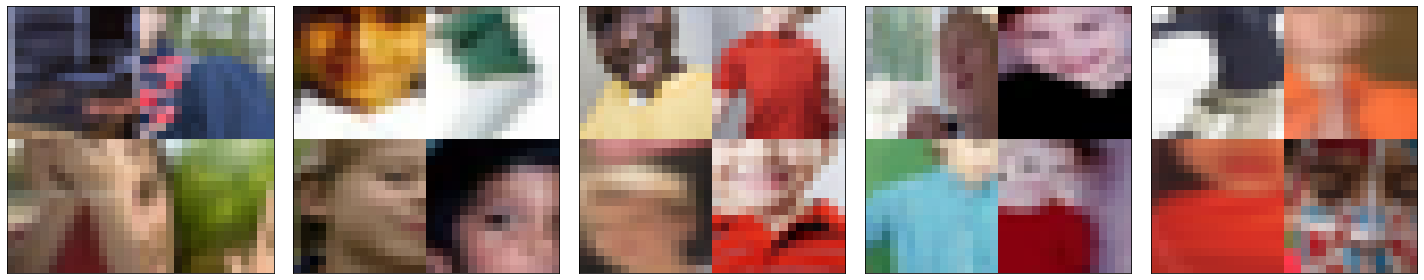

label 5,    coarse label: bed,    color: orange


<Figure size 432x288 with 0 Axes>

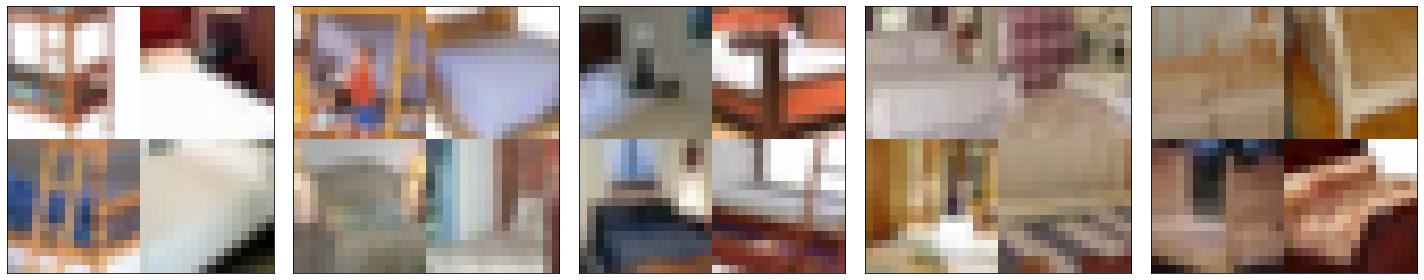

label 62,    coarse label: poppy,    color: red


<Figure size 432x288 with 0 Axes>

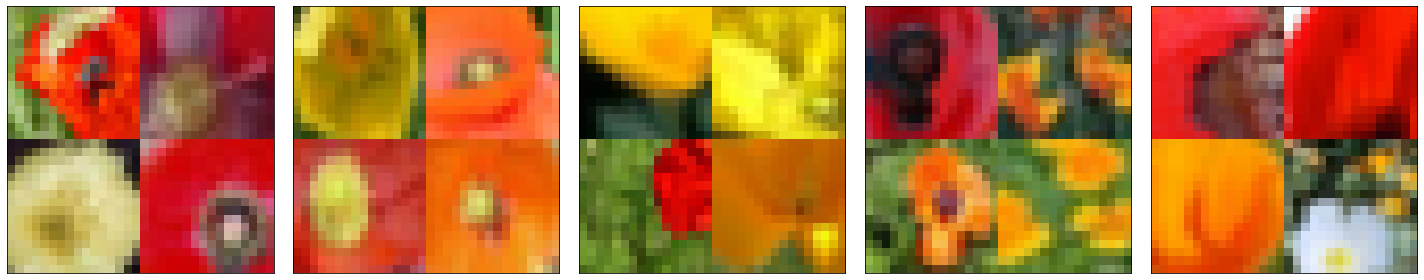

label 76,    coarse label: skyscraper,    color: black


<Figure size 432x288 with 0 Axes>

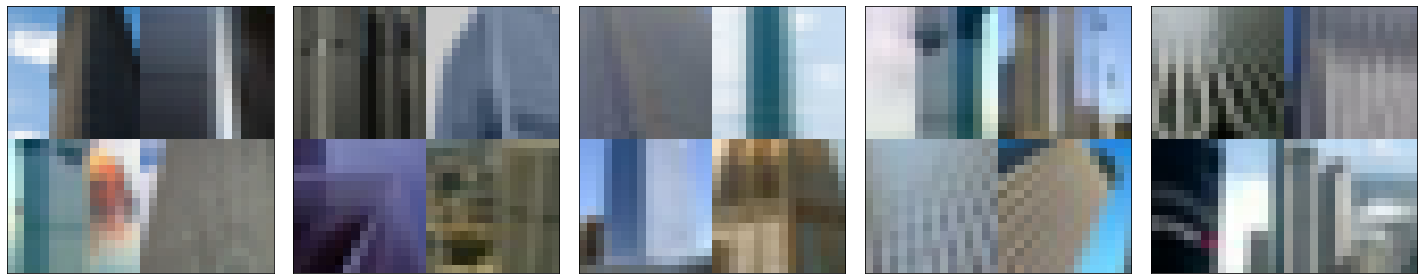

label 27,    coarse label: crocodile,    color: brown


<Figure size 432x288 with 0 Axes>

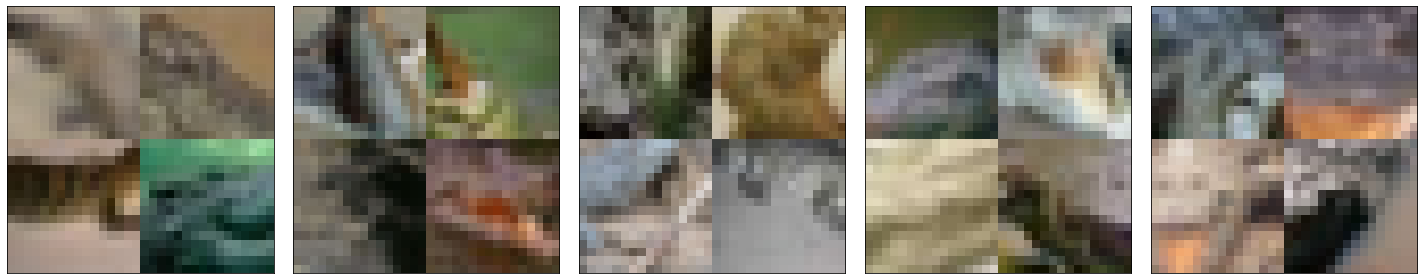

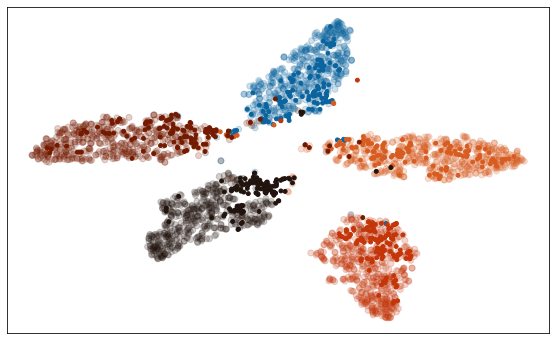

accuracy on training set: 96.12
accuracy on test set: 83.03571428571429
--------------------------------------------------------------------------------
20



accuracy on training set: 92.528
accuracy on test set: 67.08333333333333
--------------------------------------------------------------------------------
30



accuracy on training set: 82.71428571428572
accuracy on test set: 57.40489130434783
--------------------------------------------------------------------------------
40



accuracy on training set: 77.50716332378224
accuracy on test set: 49.596774193548384
--------------------------------------------------------------------------------
50



label 11,    coarse label: boy,    color: blue


<Figure size 432x288 with 0 Axes>

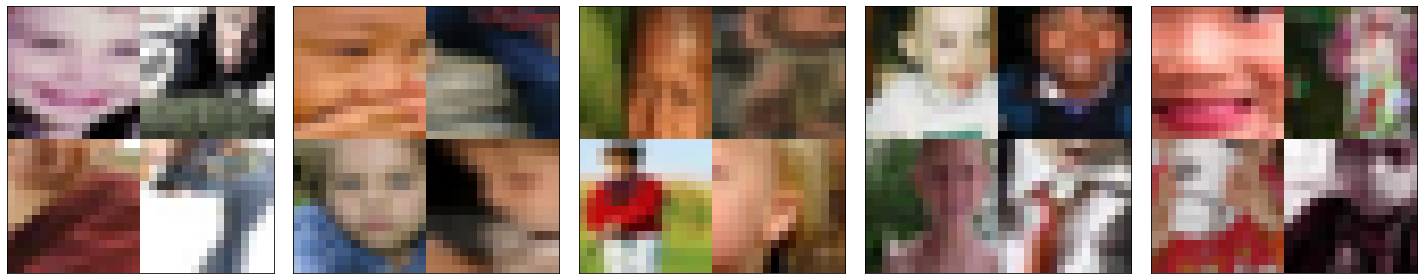

label 5,    coarse label: bed,    color: orange


<Figure size 432x288 with 0 Axes>

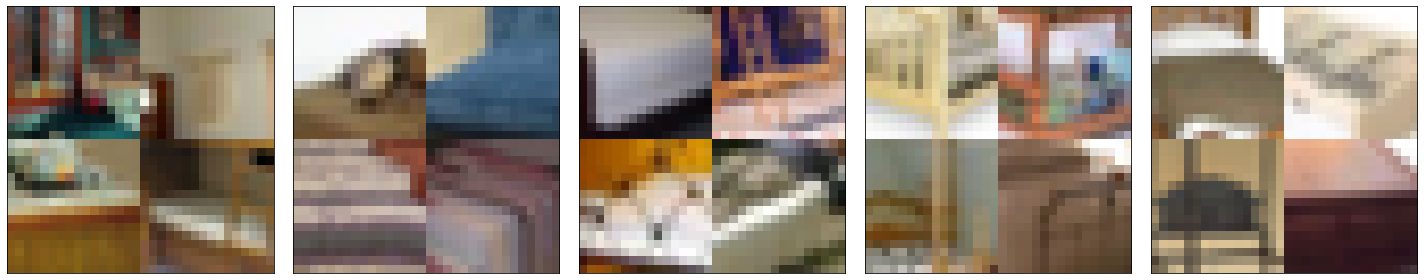

label 62,    coarse label: poppy,    color: red


<Figure size 432x288 with 0 Axes>

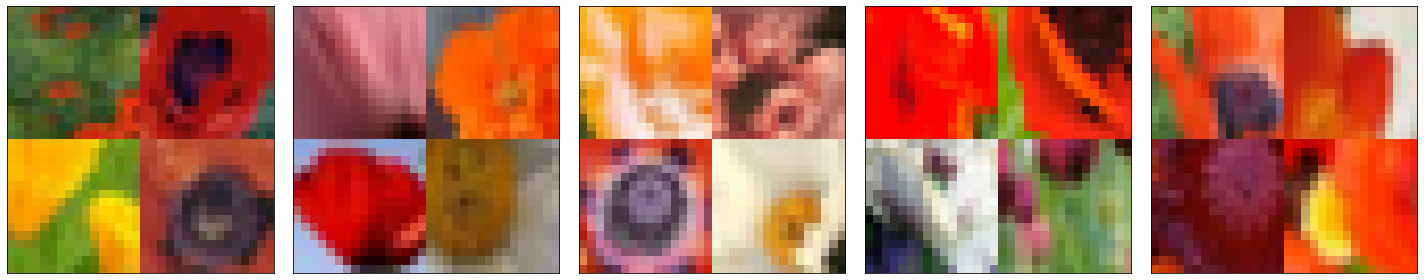

label 76,    coarse label: skyscraper,    color: black


<Figure size 432x288 with 0 Axes>

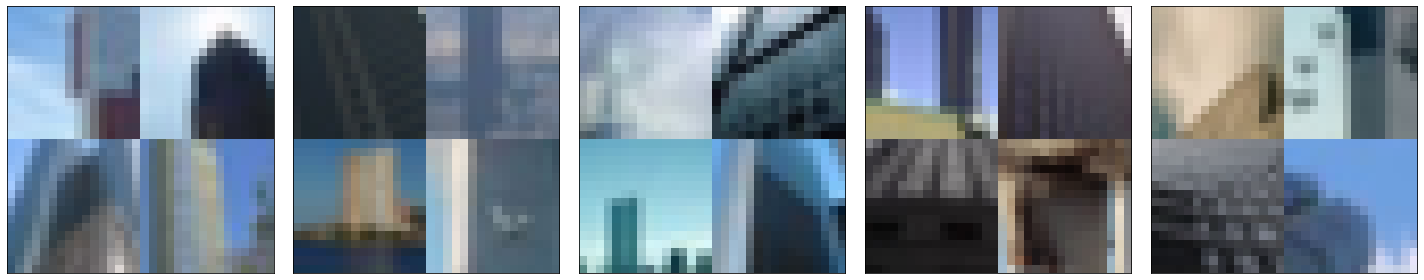

label 27,    coarse label: crocodile,    color: brown


<Figure size 432x288 with 0 Axes>

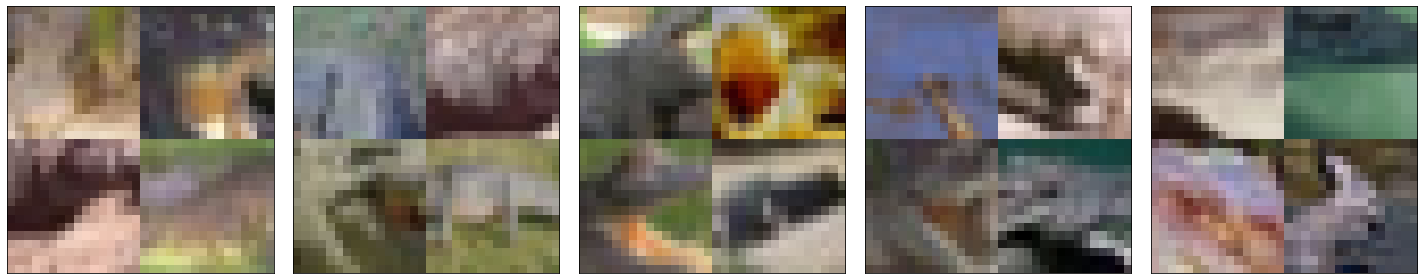

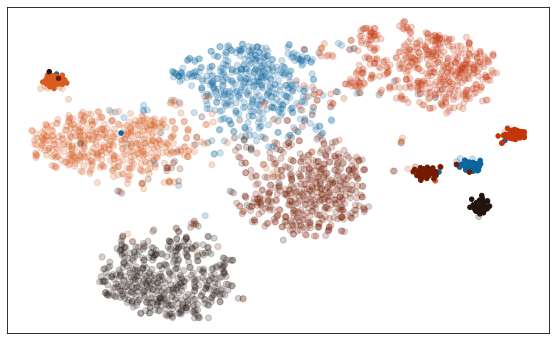

accuracy on training set: 73.9857142857143
accuracy on test set: 41.78685897435898
--------------------------------------------------------------------------------
60



accuracy on training set: 73.04285714285714
accuracy on test set: 38.12839673913043
--------------------------------------------------------------------------------
70



accuracy on training set: 70.91690544412607
accuracy on test set: 34.89583333333333
--------------------------------------------------------------------------------
80



accuracy on training set: 67.93103448275862
accuracy on test set: 31.90524193548387
--------------------------------------------------------------------------------
90



accuracy on training set: 69.34285714285714
accuracy on test set: 28.64955357142857
--------------------------------------------------------------------------------
100



label 11,    coarse label: boy,    color: blue


<Figure size 432x288 with 0 Axes>

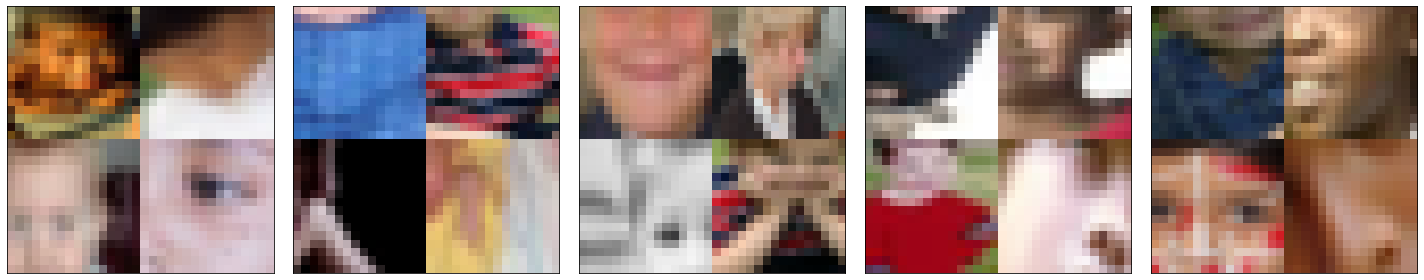

label 5,    coarse label: bed,    color: orange


<Figure size 432x288 with 0 Axes>

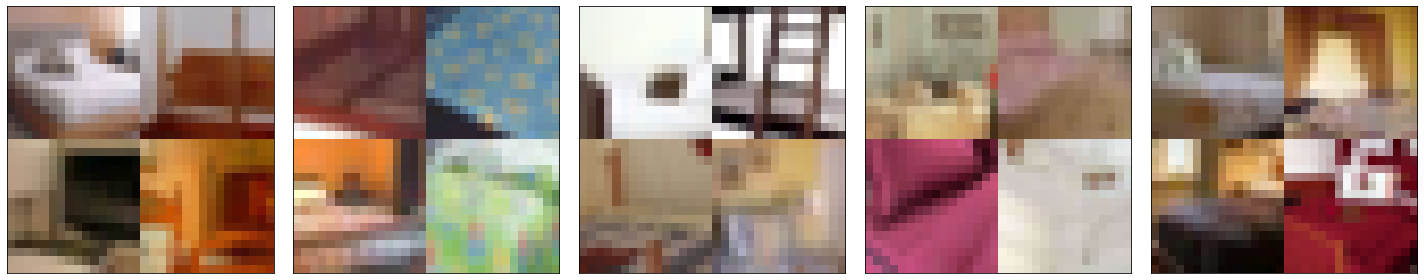

label 62,    coarse label: poppy,    color: red


<Figure size 432x288 with 0 Axes>

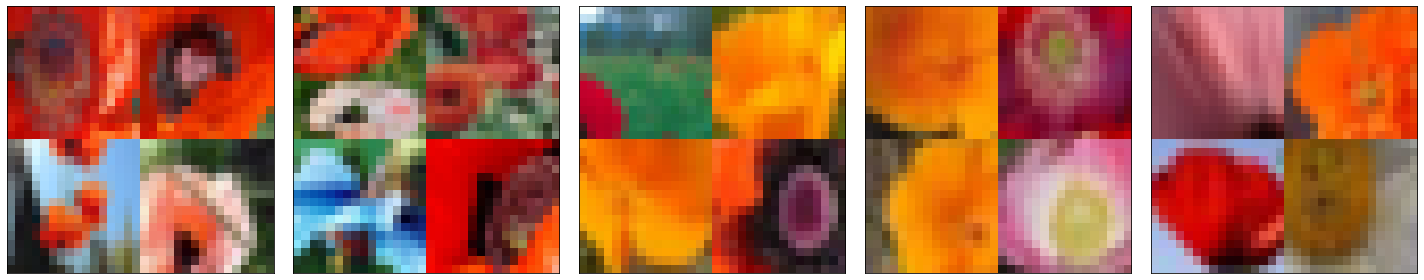

label 76,    coarse label: skyscraper,    color: black


<Figure size 432x288 with 0 Axes>

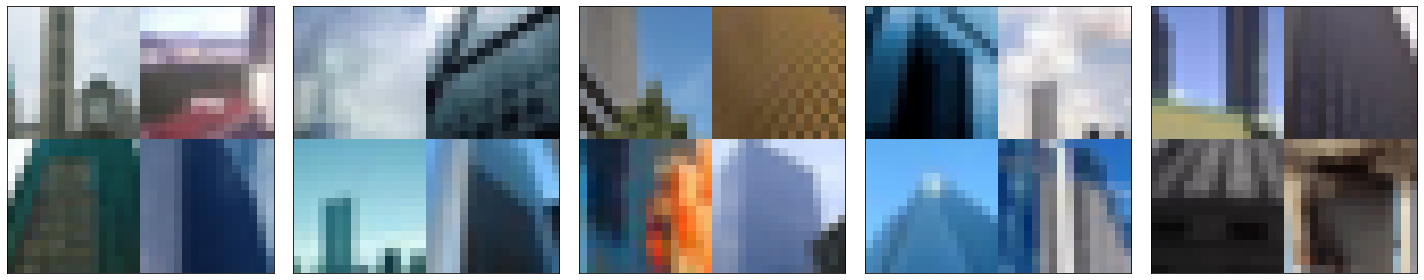

label 27,    coarse label: crocodile,    color: brown


<Figure size 432x288 with 0 Axes>

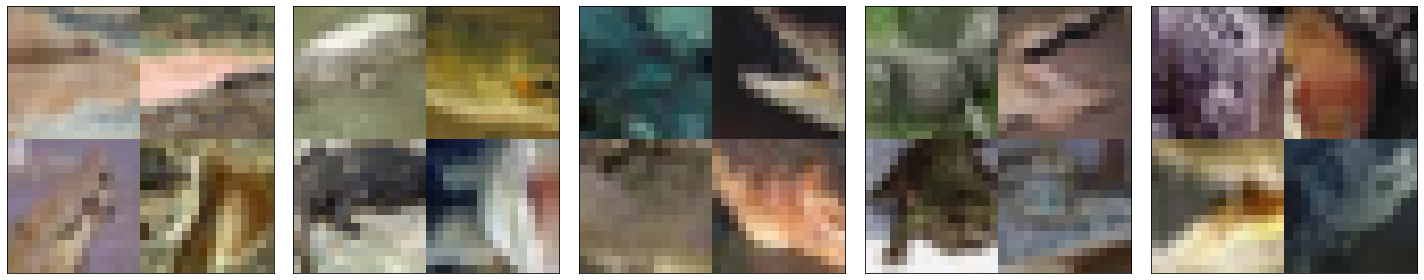

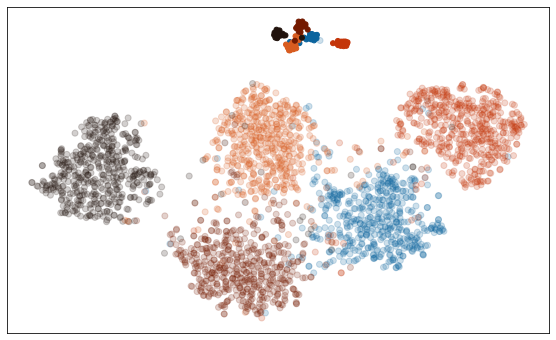

accuracy on training set: 67.96561604584527
accuracy on test set: 26.33213141025641
--------------------------------------------------------------------------------


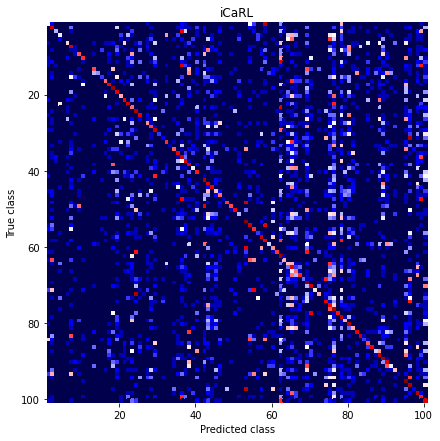

In [6]:
model = icarl(randomseed=203, name='iCarlCollage').cuda()
model.training_model()